### Import the packages

In [1]:
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import concurrent.futures
pd.set_option("display.max_columns", 100)
import warnings
warnings.filterwarnings(action="ignore")
import logging
logging.basicConfig(
    filename="vendor_clustering_elasticity_analysis_logs.log",
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO",
    encoding="utf-8"
)

### Declare some global inputs

In [76]:
lookback_period_start_date = "2022-12-01" # Add the start date of your lookback period
lookback_period_end_date = "2023-01-12" # Add the end date of your lookback period
test_data_filters = [
    # This is the configuration for one test. If you want to add more tests, please specify the parameters in the same way indicated here
    {"entity_id": "PY_CL", "test_name": "CL_20221201_R_B0_O_ElasticityCLRestaurants", "scheme_id": ["634", "635"], "ela_variants": ["Variation1"]},
]

# Bootstrap inputs
num_bootstrap_samples = 500 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)
bootstrap_level = ["user"] # Default is "user" level. We keep the legacy code that works on order level but we don't define it as an input here
analysis_level = ["test", "tier"] # Default is "test" but we use the DBDF "tier" as well. The final dataset will contain both levels of analysis
ela_lower_limit = -10 # This will delete any bootstrapped elasticity value below ela_lower_limit. Used in the plotting step
ela_upper_limit = 10 # This will delete any bootstrapped elasticity value above ela_upper_limit. Used in the plotting step

### Create the filters list based on "test_data_filters"

In [3]:
filters_list = []
for a in test_data_filters:
    for b in a["scheme_id"]:
        for c in ["Control"] + a["ela_variants"]:
            filters_list.append(" | ".join([a["entity_id"], a["test_name"], b, c]))

# Display the list. Some of the combinations won't return any data and that's fine. It is easier to create all combinations than let the user define them explicitly
filters_list

['PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 634 | Control',
 'PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 634 | Variation1',
 'PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 635 | Control',
 'PY_CL | CL_20221201_R_B0_O_ElasticityCLRestaurants | 635 | Variation1']

### Instantiate the BQ client

In [4]:
client = bigquery.Client(project="logistics-customer-staging")
bqstorage_client = bigquery_storage.BigQueryReadClient()

### Orders query

In [16]:
test_query = """
    WITH load_scheme_data AS (
        SELECT 
            entity_id,
            scheme_id,
            scheme_active_from,
            IFNULL(scheme_active_to, CURRENT_TIMESTAMP()) AS scheme_active_to,
            scheme_component_configs.travel_time_config
        FROM `fulfillment-dwh-production.cl.pricing_configuration_versions`
    ),
    
    -- Load order data and join PM data
    dps_order_raw as (
    SELECT
        -- Identifiers and supplementary fields     
        -- Date and time
        a.created_date AS created_date_utc,
        a.order_placed_at,

        -- Location of order
        ent.segment AS region,
        a.entity_id,
        a.country_code,
        a.city_name,
        a.city_id,
        a.zone_name,
        a.zone_id,

        -- Order/customer identifiers and session data
        a.perseus_client_id,
        a.variant,
        a.experiment_id AS test_id,
        b.test_name,
        a.platform_order_code,
        a.scheme_id,
        a.vendor_price_scheme_type,	-- The assignment type of the scheme to the vendor during the time of the order, such as "Automatic", "Manual", "Campaign", and "Country Fallback".
        
        -- Vendor data and information on the delivery
        a.vendor_id,
        b.target_group AS target_group_bi,
        a.is_in_treatment,
        a.chain_id,
        a.chain_name,
        a.vertical_type,
        a.delivery_status,
        a.is_own_delivery,
        a.exchange_rate,

        -- Business KPIs (These are the components of profit)
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local) AS delivery_fee_local_incl_disc_and_vouchers,
        CASE WHEN ent.segment != "MENA" THEN a.commission_local ELSE COALESCE(mn.commission_amount_lc, a.commission_local) END AS commission_local,
        a.joker_vendor_fee_local,
        COALESCE(a.service_fee_local, 0) AS service_fee_local,
        a.mov_customer_fee_local AS sof_local,
        a.delivery_costs_local,
        CASE
            WHEN ent.segment IN ("Europe", "Asia") THEN COALESCE( -- Get the delivery fee data of Pandora countries from Pandata tables
                pd.delivery_fee_local, 
                -- In 99 pct of cases, we won"t need to use that fallback logic as pd.delivery_fee_local is reliable
                IF(a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE, 0, a.delivery_fee_local)
            )
            -- If the order comes from a non-Pandora country, use delivery_fee_local
            WHEN ent.segment NOT IN ("Europe", "Asia") THEN (CASE WHEN a.is_delivery_fee_covered_by_discount = TRUE OR a.is_delivery_fee_covered_by_voucher = TRUE THEN 0 ELSE a.delivery_fee_local END)
        END AS actual_df_paid_by_customer,
        a.gfv_local,
        a.gmv_local,
        a.dps_travel_time,
        e.cluster entity_cluster,
        v.cluster area_cluster,
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` a
    LEFT JOIN `fulfillment-dwh-production.cl.dps_ab_test_orders_v2` b ON a.entity_id = b.entity_id AND a.order_id = b.order_id
    LEFT JOIN `logistics-data-storage-staging.long_term_pricing.vendors_clustered_entity` e on a.entity_id = e.entity_id and a.vendor_id = e.vendor_id 
    LEFT JOIN `logistics-data-storage-staging.long_term_pricing.vendors_clustered` v on v.entity_id = a.entity_id and a.vendor_id = v.vendor_id
    LEFT JOIN `tlb-data-prod.data_platform.fct_billing` mn ON a.platform_order_code = CAST(mn.order_id AS STRING) AND a.entity_id IN ("TB_OM", "TB_IQ", "TB_AE", "TB_KW", "YS_TR", "TB_QA", "TB_JO", "HF_EG", "HS_SA", "TB_BH")
    LEFT JOIN `fulfillment-dwh-production.pandata_curated.pd_orders` pd ON TRUE -- Contains info on the orders in Pandora countries 
        AND a.entity_id = pd.global_entity_id
        AND a.platform_order_code = pd.code 
        AND a.created_date = pd.created_date_utc -- There is no country_code field in this table
    INNER JOIN `fulfillment-dwh-production.curated_data_shared_coredata.global_entities` ent ON a.entity_id = ent.global_entity_id -- Get the region associated with every entity_id
    WHERE TRUE
        AND a.created_date between DATE("{lookback_period_start_date}") and DATE("{lookback_period_end_date}")
        AND CONCAT(a.entity_id, " | ", b.test_name, " | ", a.scheme_id, " | ", a.variant) IN ('{filters_list}')
        AND a.is_in_treatment = TRUE -- Retrieve orders in the treatment scope only
        AND a.is_sent -- Successful orders
        AND a.is_own_delivery -- OD orders only
        AND a.variant != "Original" -- Exclude orders from ASAs
        AND a.is_match_experiment_vertical
        AND (e.cluster IS NOT NULL AND e.cluster NOT IN ('Insufficient data'))
        AND (v.cluster IS NOT NULL AND v.cluster NOT IN ('Insufficient data'))
    ),

    dps_order_with_pm AS (
        SELECT
            dps.*,
            sch.* EXCEPT (entity_id, scheme_id, scheme_active_from, scheme_active_to),
            (
                SELECT MIN(tier) + 1 AS tier
                FROM UNNEST(travel_time_config) tt
                WITH OFFSET AS tier 
                WHERE dps_travel_time <= IFNULL(tt.travel_time_threshold, 999999) 
            ) AS tt_tier
        FROM dps_order_raw dps
        LEFT JOIN load_scheme_data sch ON TRUE
            AND dps.entity_id = sch.entity_id
            AND dps.scheme_id = sch.scheme_id
            AND order_placed_at >= scheme_active_from 
            AND order_placed_at < scheme_active_to 
    )
    SELECT
        a.entity_id,
        a.test_name,
        a.created_date_utc,
        a.perseus_client_id,
        a.variant,
        a.scheme_id,
        a.dps_travel_time,
        -- Vendor data and information on the delivery
        a.vendor_id,
        a.entity_cluster,
        a.area_cluster,

        -- Business KPIs (These are the components of profit)
        a.platform_order_code,
        a.dps_delivery_fee_local,
        a.dps_travel_time_fee_local,
        a.dps_surge_fee_local,
        a.delivery_fee_local,
        a.gfv_local gfv_local,
        a.gmv_local gmv_local,
        CAST(a.tt_tier AS string) tt_tier
    FROM dps_order_with_pm AS a
 """.format(lookback_period_start_date=lookback_period_start_date, lookback_period_end_date=lookback_period_end_date, filters_list="', '".join(filters_list))

# Execute the orders query
df_test_data = client.query(query=test_query).result().to_dataframe(progress_bar_type="tqdm", bqstorage_client=bqstorage_client)

# Change the data types of numeric columns to FLOAT
numeric_cols = ["dps_delivery_fee_local", "dps_travel_time_fee_local", "dps_surge_fee_local", "delivery_fee_local", "gfv_local", "gmv_local"]
df_test_data[numeric_cols] = df_test_data[numeric_cols].applymap(lambda x: float(x))

# Change scheme_id to INT
df_test_data["scheme_id"] = df_test_data["scheme_id"].apply(lambda x: int(x))

# Add the DF/AFV column
df_test_data["df_afv"] = (df_test_data["delivery_fee_local"] / df_test_data["gfv_local"]) * 100

df_test_data.head()

Downloading: 100%|██████████|


,entity_id,test_name,created_date_utc,perseus_client_id,variant,scheme_id,dps_travel_time,vendor_id,entity_cluster,area_cluster,platform_order_code,dps_delivery_fee_local,dps_travel_time_fee_local,dps_surge_fee_local,delivery_fee_local,gfv_local,gmv_local,tt_tier,df_afv
0,PY_CL,CL_20221201_R_B0_O_ElasticityCLRestaurants,2023-01-02,1604277515596.2116204750.snvmzjbwhe,Variation1,634,8.745070168,162668,"High basket, low distance","High basket, low distance",705703190,2090.0,1290.0,800.0,2090.0,13290.0,15910.0,4,15.726110
1,PY_CL,CL_20221201_R_B0_O_ElasticityCLRestaurants,2022-12-24,1669675392681.9940092658.zyxdkepqwo,Control,635,6.766886234,112284,"Low basket, low distance","Low basket, low distance",700688062,1390.0,1090.0,300.0,1390.0,6370.0,8110.0,4,21.821036
2,PY_CL,CL_20221201_R_B0_O_ElasticityCLRestaurants,2023-01-02,1665679139225.966956740100048126.iJz6XAeulg,Variation1,634,8.524667208,321401,"High basket, high distance",Central cluster,705744857,1690.0,1290.0,400.0,1690.0,20000.0,22490.0,4,8.450000
3,PY_CL,CL_20221201_R_B0_O_ElasticityCLRestaurants,2023-01-02,1670123893939.170756572089143798.bTXu8Xk9WA,Control,635,2.432850028,101164,Central cluster,Central cluster,705847682,590.0,490.0,100.0,590.0,12890.0,14000.0,1,4.577192
4,PY_CL,CL_20221201_R_B0_O_ElasticityCLRestaurants,2023-01-02,1672446091750.439476435598721435.fYq3oIw7Yh,Control,635,5.361822930,108478,"Low basket, low distance","High basket, low distance",705775549,1390.0,890.0,500.0,1390.0,27760.0,23380.0,3,5.007205


### Define a function to run the bootstrapping analysis in parallel

In [25]:
# Define a function to run the bootstrap analysis sequentially
def run_bootstrap(analysis_level, bootstrap_level, test_name, cluster_type, vendor_label, price_tier, ela_variant, sample_num, sim_counter):
    """
    A function to run the bootstramp analysis by bootstrapping on order or user level.
    The parameters of the function can take the following values...
    
    1- analysis_level --> "test" or "tier". Depending on the value of this parameter, you can run the bootstrapping analysis on the test level or on each individual TT tier
    2- bootstrap_level --> "user" or "order". It is always recommended to bootstrap the users and then calculate the KPIs compared to bootstrapping on orders
    3- test_name --> The test names that you're considering in the analysis
    4- cluster_type --> The granularity of the vendor clustering output. This parameter can take the value of "area" or "entity". Areas are defined by GPT using order volume as the metric to assess the "importance" of logistics zones
    5- vendor_label --> Can take the values of "Low basket, low distance"; "Low basket, high distance"; "Central cluster"; "High basket, low distance"; "High basket, high distance"
    6- price_tier --> The DBDF tier number of the elasticity test's variants. Typically, both variants have the same number of tiers
    7- ela_variant --> The variant that has a different price compared to the control group and from which we will calculate an elasticity value
    """

    # Filter for the right subset of data
    if analysis_level == "test":
        df_sub_test = df_test_data[(df_test_data["test_name"] == test_name) & (df_test_data[cluster_type] == vendor_label)]
        price_tier = "All" # If analysis_level = "test", override the price tier with "All"
    elif analysis_level == "tier":
        df_sub_test = df_test_data[(df_test_data["test_name"] == test_name) & (df_test_data[cluster_type] == vendor_label) & (df_test_data["tt_tier"] == price_tier)]

    logging.info(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {test_name}, cluster_type: {cluster_type}, vendor_group_label: {vendor_label}, price_tier:{price_tier}, ela_variant: {ela_variant}, sample_num: {sample_num}, sim_counter: {sim_counter}")

    if bootstrap_level == "user":
        # Retrieve the distinct perseus_client_ids under the control group
        df_ctl_perseus_ids = pd.DataFrame(
            data=df_sub_test[(df_sub_test["variant"] == "Control")]["perseus_client_id"].unique(),
            columns=["perseus_client_id"]
        ).sample(frac=1, replace=True).reset_index(drop=True)

        # Retrieve the distinct perseus_client_ids under the elasticity variant
        df_var_perseus_ids = pd.DataFrame(
            data=df_sub_test[(df_sub_test["variant"] == ela_variant)]["perseus_client_id"].unique(),
            columns=["perseus_client_id"]
        ).sample(frac=1, replace=True).reset_index(drop=True)

        # Create a data frames that will contain all the orders placed by the sampled perseus_client_ids from the control group
        df_ctl_sample = pd.merge(
            left=df_ctl_perseus_ids,
            right=df_sub_test,
            on=["perseus_client_id"],
            how="left"
        )

        # Create a data frames that will contain all the orders placed by the sampled perseus_client_ids from the variant group
        df_var_sample = pd.merge(
            left=df_var_perseus_ids,
            right=df_sub_test,
            on=["perseus_client_id"],
            how="left"
        )
    elif bootstrap_level == "order":
        df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
        df_var_sample = df_sub_test[df_sub_test["variant"] == ela_variant].sample(frac=1, replace=True)
    
    num_orders_ctl = df_ctl_sample["platform_order_code"].count()
    num_orders_var = df_var_sample["platform_order_code"].count()

    avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
    avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

    avg_tt_fee_ctl = df_ctl_sample["dps_travel_time_fee_local"].sum() / num_orders_ctl
    avg_tt_fee_var = df_var_sample["dps_travel_time_fee_local"].sum() / num_orders_var

    pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
    pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)
    pct_diff_tt_fee = float((avg_tt_fee_var - avg_tt_fee_ctl) / avg_tt_fee_ctl)

    # Elasticity is calculated by pct difference in orders / pct difference in average DF
    elasticity = pct_diff_orders / pct_diff_avg_df
    avg_df_afv_var = float(df_var_sample["delivery_fee_local"].sum() / df_var_sample["gfv_local"].sum())

    output_dict = {
        "analysis_level": analysis_level,
        "bootstrap_level": bootstrap_level,
        "test_name": test_name,
        "cluster_type": cluster_type,
        "vendor_group_label": vendor_label,
        "price_tier": price_tier,
        "ela_variant": ela_variant,
        "sample_num": sample_num,
        "avg_df_ctl": avg_df_ctl,
        "avg_df_var": avg_df_var,
        "avg_tt_fee_ctl": avg_tt_fee_ctl,
        "avg_tt_fee_var": avg_tt_fee_var,
        "orders_tier_ctl": num_orders_ctl,
        "orders_tier_var": num_orders_var,
        "total_orders_tier": num_orders_ctl + num_orders_var,
        "elasticity": elasticity,
        "pct_diff_orders": pct_diff_orders,
        "pct_diff_avg_df": pct_diff_avg_df,
        "pct_diff_tt_fee": pct_diff_tt_fee,
        "df_afv": avg_df_afv_var
    }

    df_sim_results = pd.DataFrame([output_dict])

    return df_sim_results

In [26]:
# Define the looping parameters that will be used to define the arguments to be passed to the concurrent.futures method
test_names = df_test_data["test_name"].unique().tolist()
clusters = ["area_cluster", "entity_cluster"]
vendor_labels = df_test_data["entity_cluster"].unique().tolist()

sample_num = np.arange(1, num_bootstrap_samples + 1)

# Define the arguments that will be used in the concurrent.futures method
args_names = []
sim_counter = 1
for anl in analysis_level: # Loop over all analysis levels
    for boot in bootstrap_level: # Loop over all bootstrap levels
        for i in test_names: # Loop over all test names
            for j in clusters: # Loop over all cluster types
                for k in vendor_labels: # Loop over all vendor labels
                    # Get the price tiers associated with the analysis level
                    if anl == "test":
                        price_tiers = ["All"]
                    elif anl == "tier":
                        price_tiers = [tt for tt in df_test_data["tt_tier"].unique().tolist()]
                        price_tiers.sort()
                    for l in price_tiers: # Loop over all price tiers
                        for filter in test_data_filters: # Loop over all elements in the test_data_filters list
                            if filter["test_name"] == i:
                                ela_variants = filter["ela_variants"] # Find the ela_variants corresponding to the test
                                for m in ela_variants: # Loop over all ela_variants defined in the previous step
                                    for s in sample_num: # Loop over all sample numbers
                                        arg_iter = tuple([anl, boot, i, j, k, l, m, s, sim_counter])
                                        args_names.append(arg_iter)
                                        sim_counter += 1
                            else:
                                continue

# Print a message showing the total number of simulations
print(f"The total number of simulations is: {len(args_names)}")

The total number of simulations is: 30000


In [27]:
# Define a function to execute bootstrap_func in parallel or sequentially
def execute_bootstrap_func(mode):
    # Declare two empty lists that will contain the results of the simulations
    df_sim_results = []
    df_failed = []

    if mode == "parallel":
        # Use concurrent.futures to call the "run_bootstrap" on the list of arguments defined above
        # This returns a futures object containing the return value of the function, including any exceptions
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {executor.submit(run_bootstrap, arg[0], arg[1], arg[2], arg[3], arg[4], arg[5], arg[6], arg[7], arg[8]): arg for arg in args_names}

        # Process each result as it is available and append it to df_sim_results. The elements will be added in the order the task is completed, not the order in which they are listed
        for future in concurrent.futures.as_completed(futures):
            try:
                df_sim_results.append(future.result())
            except Exception as err:
                df_failed.append(futures[future][0])

    elif mode == "sequential":
        for arg in args_names:
            df_sim_results.append(
                run_bootstrap(
                    analysis_level=arg[0],
                    bootstrap_level=arg[1],
                    test_name=arg[2],
                    cluster_type=arg[3],
                    vendor_label=arg[4],
                    price_tier=arg[5],
                    ela_variant=arg[6],
                    sample_num=arg[7],
                    sim_counter=arg[8]
                )
            )
    
    # Convert df_sim_results from a list to a pandas data frame
    df_sim_results = pd.concat(df_sim_results)

    # Reset the index
    df_sim_results = df_sim_results.reset_index(drop=True)

    return df_sim_results

In [20]:
# Invoke "execute_bootstrap_func"
df_sim_results = execute_bootstrap_func(mode="parallel")

In [45]:
# Calculate the mean elasticity of All the clusters per price tier.
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "df_afv": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats = df_sim_results.groupby(["analysis_level", "bootstrap_level", "test_name", "cluster_type", "vendor_group_label", "price_tier", "ela_variant"])\
    [["elasticity", "pct_diff_orders", "pct_diff_avg_df", "df_afv"]].agg(agg_func_selection).reset_index()
df_stats.head()

analysis_level bootstrap_level                                   test_name  \
                                                                               
0           test            user  CL_20221201_R_B0_O_ElasticityCLRestaurants   
1           test            user  CL_20221201_R_B0_O_ElasticityCLRestaurants   
2           test            user  CL_20221201_R_B0_O_ElasticityCLRestaurants   
3           test            user  CL_20221201_R_B0_O_ElasticityCLRestaurants   
4           test            user  CL_20221201_R_B0_O_ElasticityCLRestaurants   

   cluster_type          vendor_group_label price_tier ela_variant elasticity  \
                                                                         mean   
0  area_cluster             Central cluster        All  Variation1  -0.135618   
1  area_cluster  High basket, high distance        All  Variation1  -0.157033   
2  area_cluster   High basket, low distance        All  Variation1  -0.111806   
3  area_cluster   Low basket, high distance        All  Variation1  -0.075759   
4  area_cluster    Low basket, low distance        All  Variation1  -0.099047   

                                      df_afv                                   \
  percentile_left percentile_right      mean percentile_left percentile_right   
0       -0.178249        -0.096294  0.076921        0.076565         0.077257   
1       -0.204222        -0.110276  0.061179        0.060782         0.061535   
2       -0.155046        -0.063983  0.056082        0.055735         0.056460   
3       -0.132251        -0.018817  0.095185        0.094515         0.095797   
4       -0.139447        -0.056590  0.086194        0.085764         0.086616   

  pct_diff_orders                                  pct_diff_avg_df  \
             mean percentile_left percentile_right            mean   
0       -0.028394       -0.037471        -0.020161        0.209368   
1       -0.031672       -0.040950        -0.022137        0.201683   
2       -0.025045       -0.034487        -0.014442        0.223948   
3       -0.015208       -0.026607        -0.003783        0.200752   
4       -0.023048       -0.032566        -0.013219        0.232656   

                                    
  percentile_left percentile_right  
0        0.204783         0.213573  
1        0.195959         0.207176  
2        0.217649         0.230522  
3        0.194609         0.206827  
4        0.228283         0.237273

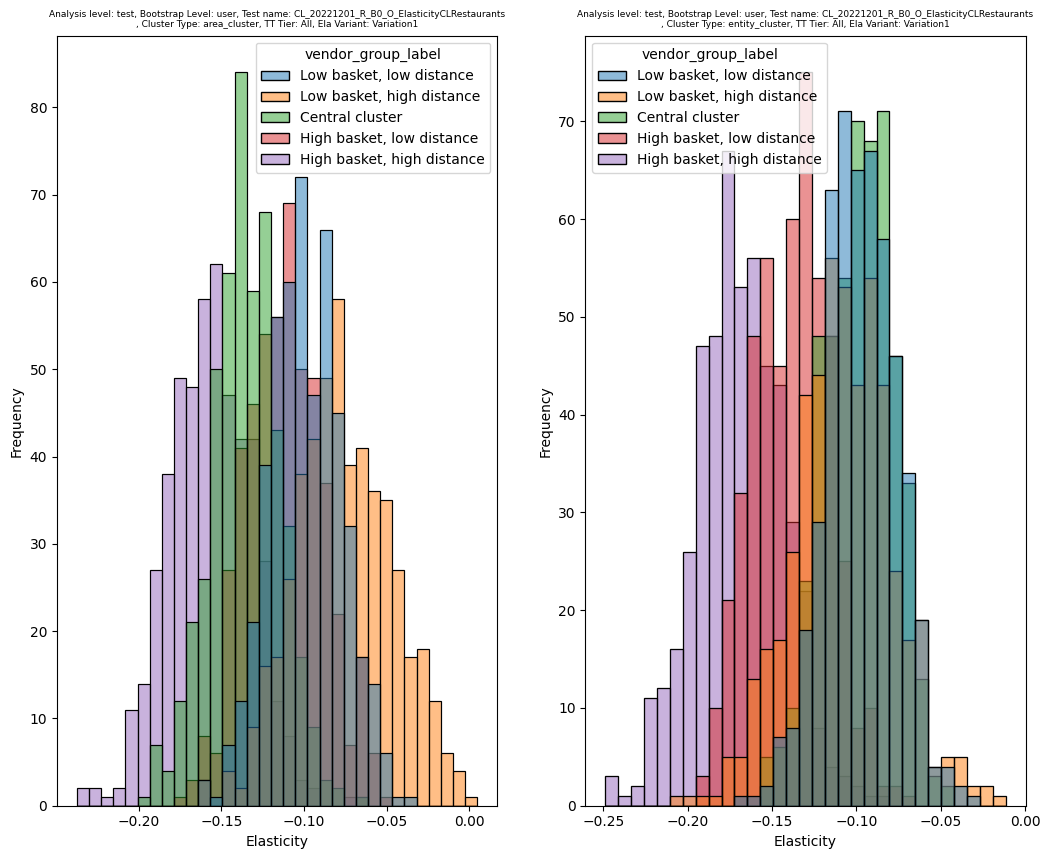

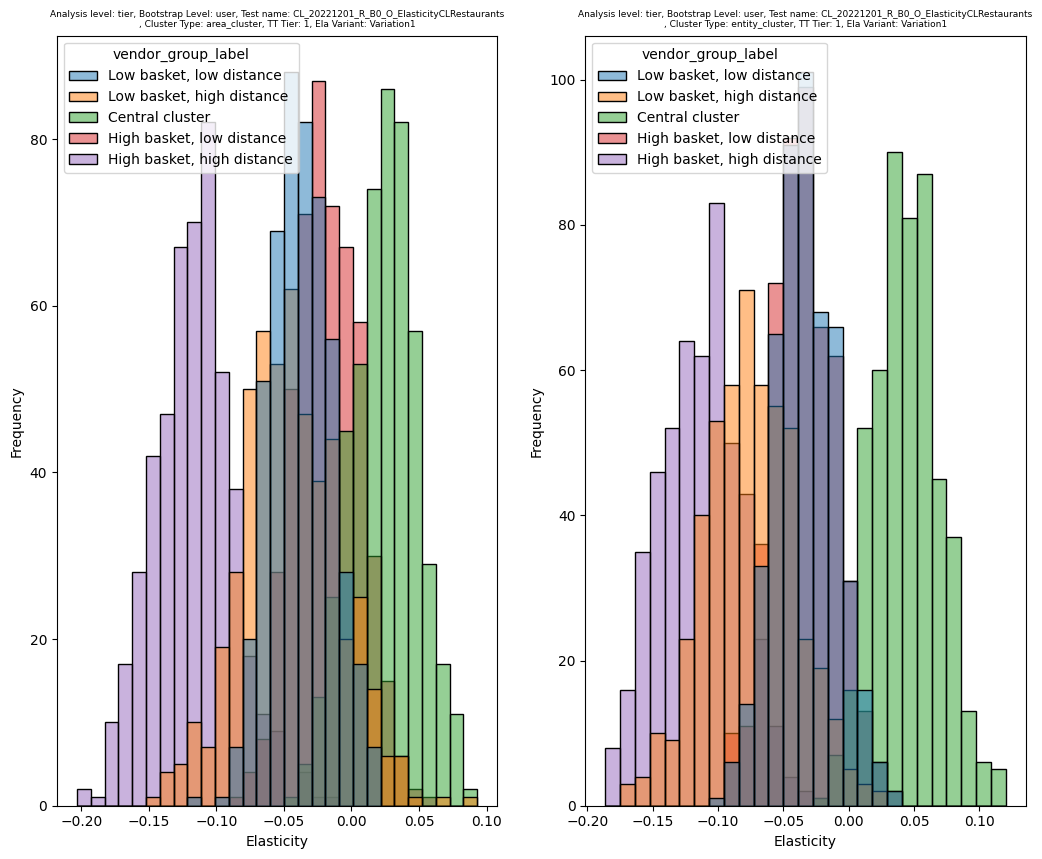

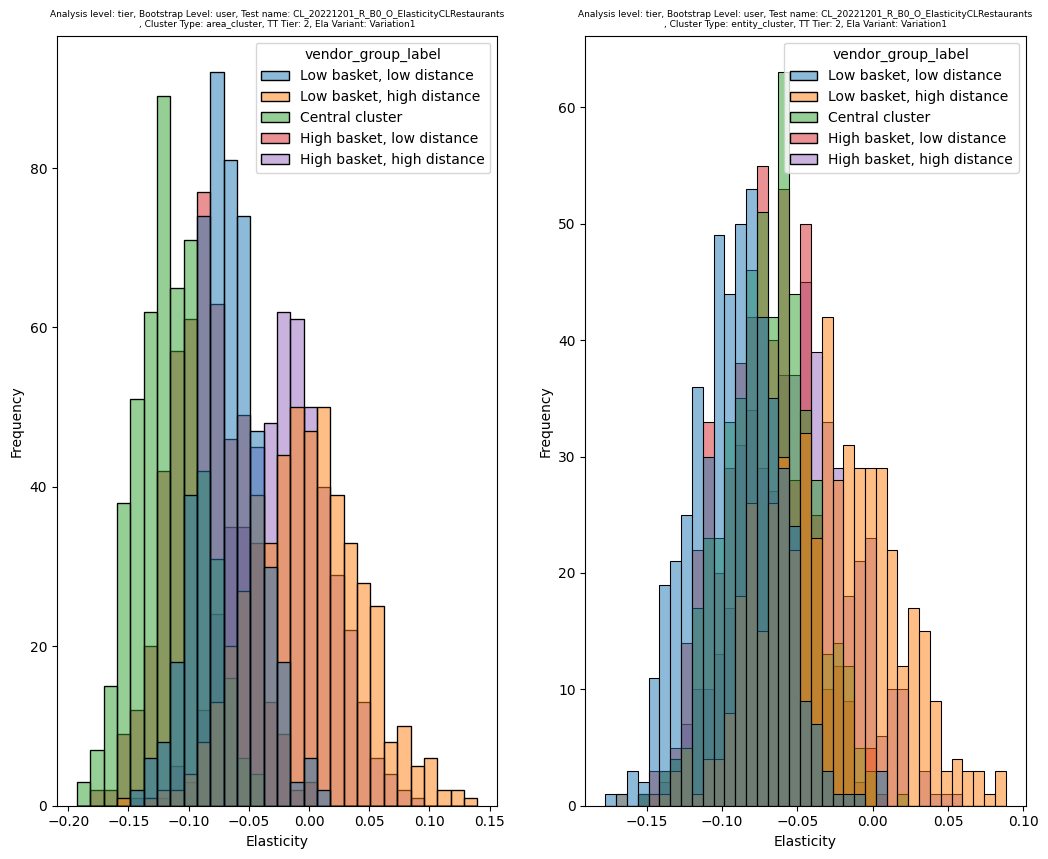

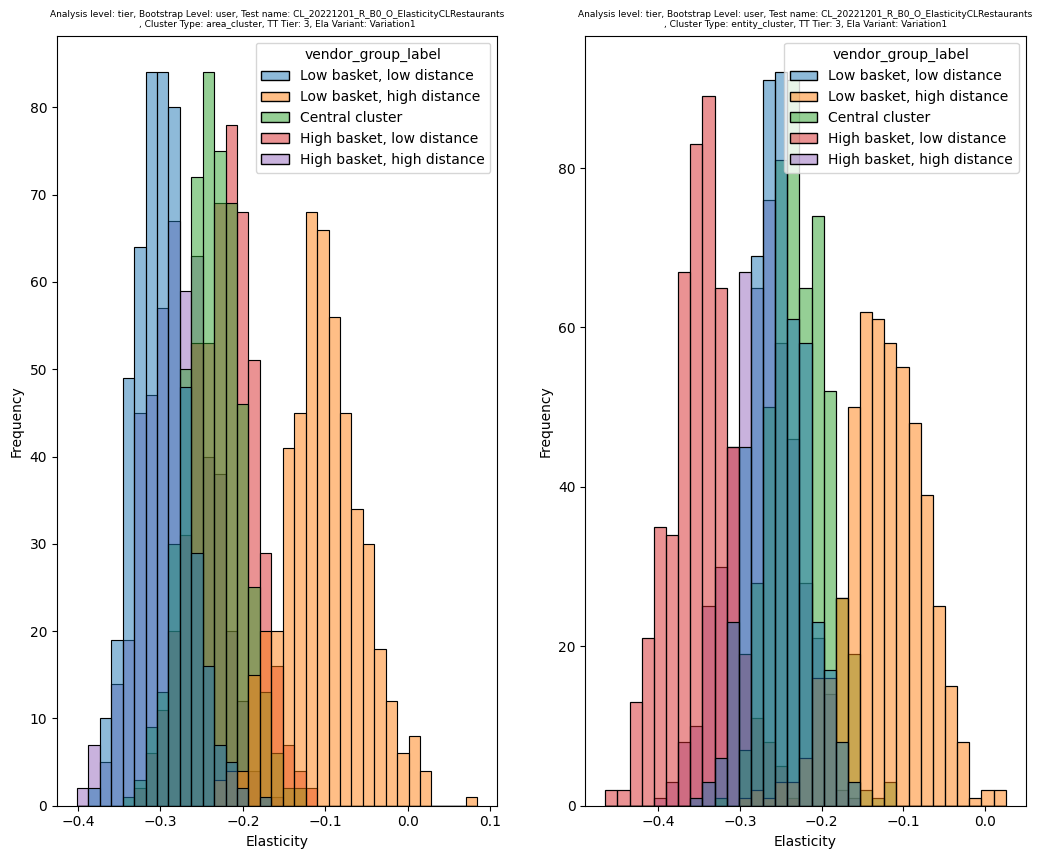

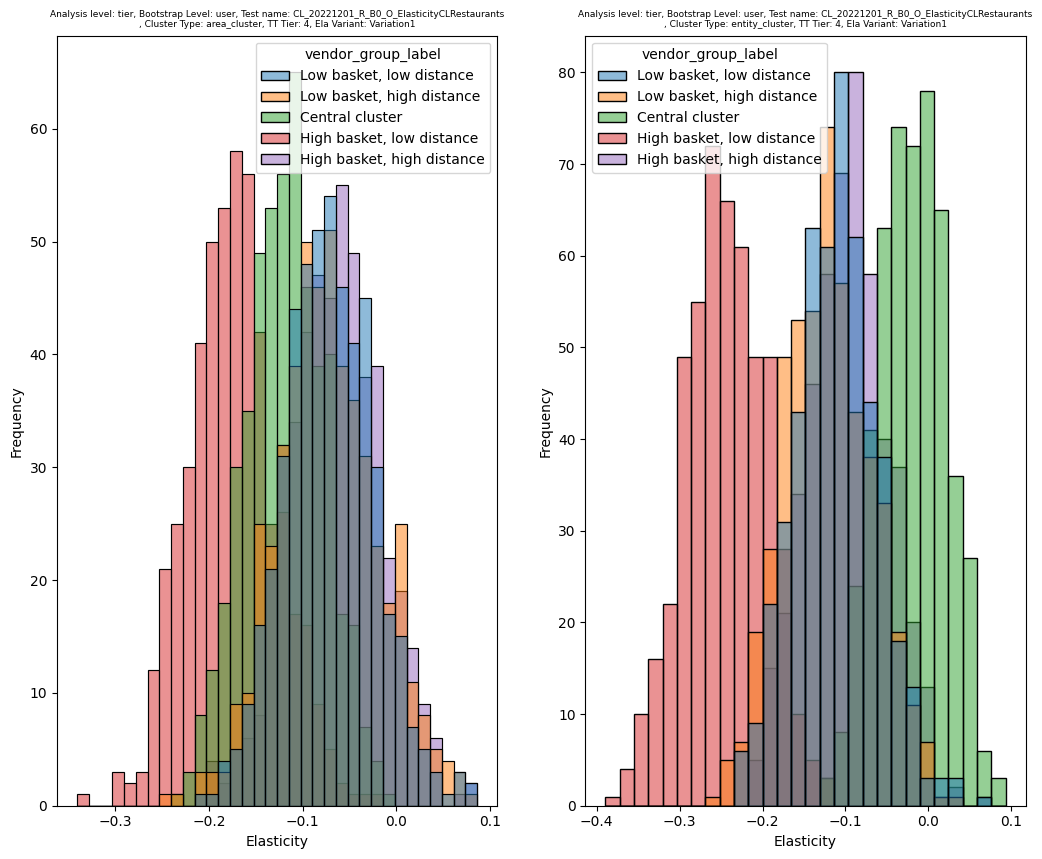

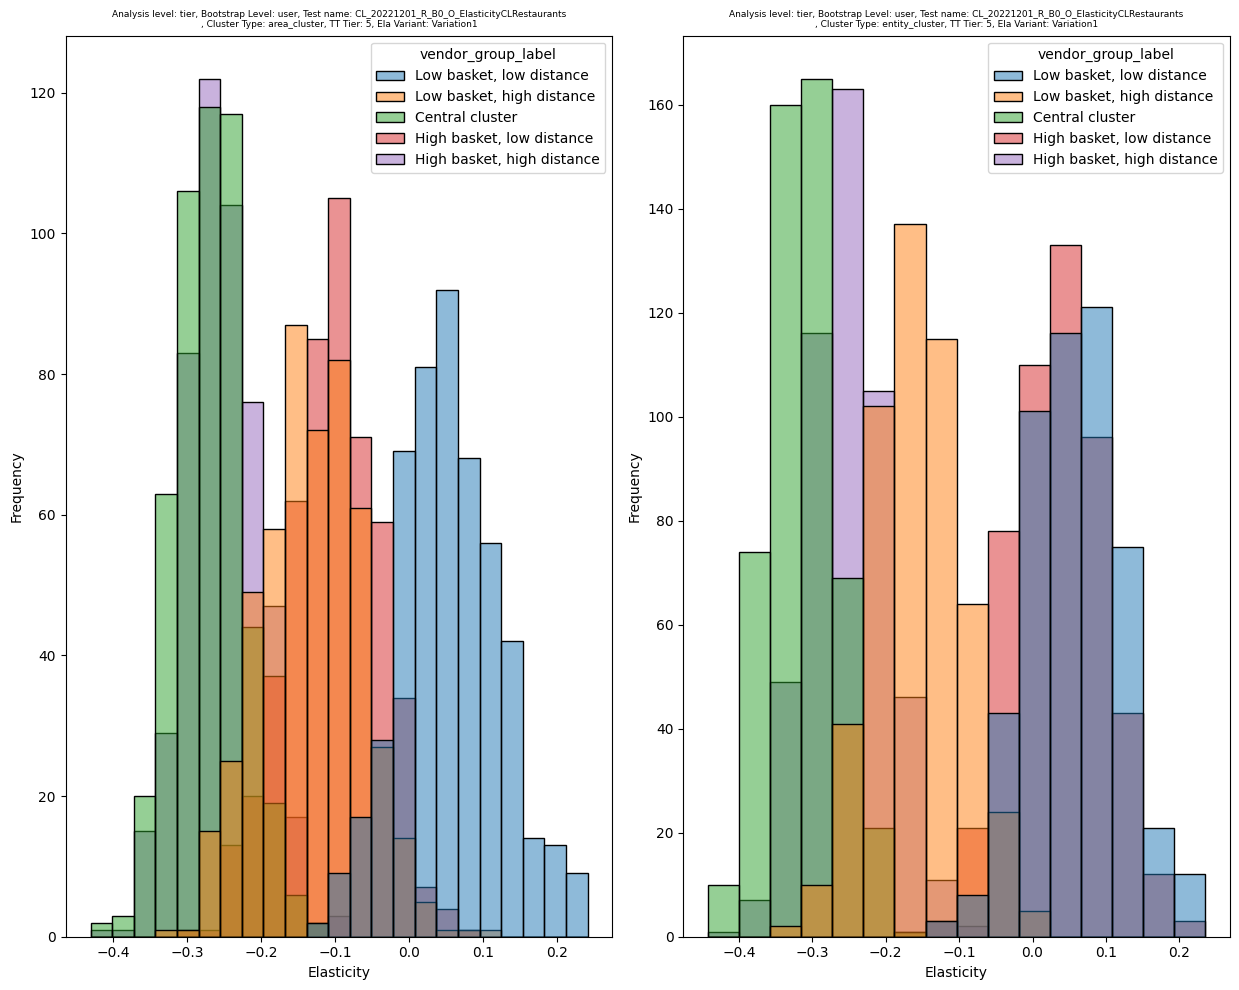

In [94]:
def generate_plot():
    # Extract the bootstrap levels to loop over
    loop_analysis_lvls = df_sim_results["analysis_level"].drop_duplicates().reset_index(drop=True)

    # Extract the bootstrap levels to loop over
    loop_bootstrap_lvls = df_sim_results["bootstrap_level"].drop_duplicates().reset_index(drop=True)

    # Extract the tests to loop over
    loop_tests = df_sim_results["test_name"].drop_duplicates().reset_index(drop=True)

    # Create a data frame showing all combinations of test/ela_variant to loop over
    loop_test_var_combos = df_sim_results[["test_name", "ela_variant"]].drop_duplicates().reset_index(drop=True)

    # Create a data frame showing all combinations of test/price tier to loop over
    loop_test_tier_combos = df_sim_results[df_sim_results["price_tier"] != "All"][["test_name", "price_tier"]].drop_duplicates().reset_index(drop=True)

    # Define the desired hue order
    desired_hue_order = [vendor_labels[1], vendor_labels[4], vendor_labels[3], vendor_labels[0], vendor_labels[2]]

    # Iterate over all bootstrap levels, test names, and ela_variants and create the histograms
    for anl in loop_analysis_lvls:
        for boot in loop_bootstrap_lvls:
            for tst in loop_tests:
                # Extract all the variants belonging to the test to loop through
                loop_var = loop_test_var_combos[loop_test_var_combos["test_name"]==tst]["ela_variant"].tolist()
                
                # Extract all the price tiers to loop through depending on the value of the parameter "anl"
                if anl == "test":
                    loop_price_tier = ["All"]
                elif anl == "tier":
                    loop_price_tier = loop_test_tier_combos["price_tier"].tolist()
                
                # Continue the looping...
                for tier in loop_price_tier:
                    for var in loop_var:
                        # Create subplots
                        fig, axs = plt.subplots(
                            nrows=1,
                            ncols=len(df_sim_results["cluster_type"].unique()),
                            figsize=(12.5, 10)
                        )
                        for idx, clust in enumerate(clusters):
                            # Filter df_sim_results for the right subset of data
                            df_iter = df_sim_results[
                                (df_sim_results["analysis_level"] == anl) &
                                (df_sim_results["bootstrap_level"] == boot) &
                                (df_sim_results["test_name"] == tst) &
                                (df_sim_results["cluster_type"] == clust) &
                                (df_sim_results["price_tier"] == tier) &
                                (df_sim_results["ela_variant"] == var) &
                                (df_sim_results["elasticity"] >= ela_lower_limit) &
                                (df_sim_results["elasticity"] <= ela_upper_limit)
                            ]

                            # Plot the histogram
                            ax = axs[idx]
                            sns.histplot(data=df_iter, x="elasticity", hue="vendor_group_label", hue_order=desired_hue_order, ax=ax)
                            ax.set_title(f"Analysis level: {anl}, Bootstrap Level: {boot}, Test name: {tst},\n Cluster Type: {clust}, TT Tier: {tier}, Ela Variant: {var}", fontdict={"fontsize": 7})
                            ax.set_xlabel("Elasticity")
                            ax.set_ylabel("Frequency")

    # Adjust the space between the subplots
    plt.tight_layout()

# Invoke the plotting function
generate_plot()

### EXECUTE THIS CELL WITH CAUTION BECAUSE IT WILL ADD DATA TO THE BQ TABLE

In [44]:
# Upload the data frame to BigQuery
job_config = bigquery.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
client.load_table_from_dataframe(
    dataframe=df_sim_results,
    destination="logistics-data-storage-staging.long_term_pricing.vendor_clustering_elasticity_tests_sim_results",
    job_config=job_config
).result()

LoadJob<project=logistics-customer-staging, location=US, id=4a071390-9e4f-4d65-b0b0-b8adc9514a42>